## Create and test ion channel model

In [1]:
from experiments.ica_Li import (Li_iv_80,
                               Li_iv_60,
                                Li_iv_40,
                               Li_act,
                               Li_inact_1000,
                                Li_inact_300,
                                Li_inact_150,
                                Li_inact_kin_40,
                                Li_inact_kin_60,
                                Li_inact_kin_80,
                                Li_recov_80,
                                Li_recov_40
                               )

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/nygren_IcaL.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,Li_iv_80,
                                                Li_act,
                                                Li_inact_300,
                                               Li_recov_80)
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [25]:

# 
#'membrane.Cm' : (0.0001,1), # keep it off 

limits_g_cal_log = {'log_i_caL.g_Ca_L' : (0,20),
          'i_caL.E_Ca_app' : (0,100),
          'i_caL.p1': (0,20),
          'i_caL.p2': (-10,10),
          'log_i_caL.p3': (-7,-3),
          'i_caL.p4': (20,60),
          'i_caL.p5': (20,60),
          'log_i_caL.p6': (-7,-3),
          'i_caL.q1': (10,50),
          'i_caL.q2': (-10,10),
          'log_i_caL.q3': (-2,0),
          'i_caL.q4': (20,60),
          'i_caL.q5': (-10,25),
          'log_i_caL.q6': (-3,-1),
          'log_i_caL.r1': (-1,1),
          'i_caL.r2': (-10,60),
          'i_caL.r3': (-10,30),
          'log_i_caL.r4': (-4,-2)}

limits_g_cal = {'i_caL.g_Ca_L' : (0,20),
          'i_caL.E_Ca_app' : (0,100),
          'i_caL.p1': (0,20),
          'i_caL.p2': (-10,10),
          'log_i_caL.p3': (-7,-3),
          'i_caL.p4': (20,60),
          'i_caL.p5': (20,60),
          'log_i_caL.p6': (-7,-3),
          'i_caL.q1': (10,50),
          'i_caL.q2': (-10,10),
          'log_i_caL.q3': (-2,0),
          'i_caL.q4': (20,60),
          'i_caL.q5': (-10,25),
          'log_i_caL.q6': (-3,-1),
          'log_i_caL.r1': (-1,1),
          'i_caL.r2': (-10,60),
          'i_caL.r3': (-10,30),
          'log_i_caL.r4': (-4,-2)}
"""
limits = {'log_i_caL.g_Ca_L' : (0,1),
          'i_caL.E_Ca_app' : (59,61),
          'i_caL.p1': (8,10),
          'i_caL.p2': (-10,0),
          'log_i_caL.p3': (-4,-3),
          'i_caL.p4': (34,36),
          'i_caL.p5': (29,31),
          'log_i_caL.p6': (-4,-3),
          'i_caL.q1': (25,30),
          'i_caL.q2': (6.5,7.5),
          'log_i_caL.q3': (-1,0),
          'i_caL.q4': (39,41),
          'i_caL.q5': (14,15),
          'log_i_caL.q6': (-2,-1),
          'log_i_caL.r1': (0,1),
          'i_caL.r2': (39,41),
          'i_caL.r3': (14,15),
          'log_i_caL.r4': (-3,-2)}
"""
limits = limits_g_cal
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [6]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "nygren_icaL_testing.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 262144 particles


In [22]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000), #Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=0.4964),
             sampler=MulticoreEvalParallelSampler(n_procs=40),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.4540146665002014, '1': 1.4540146665002014, '2': 1.4540146665002014, '3': 1.4540146665002014, '4': 1.4540146665002014, '5': 0.5344955085837587, '6': 0.3117408492636455, '7': 0.33011156554043614, '8': 0.20783794227419577, '9': 0.2338146729143796, '10': 0.4488429899591634, '11': 1.4540146665002014, '12': 1.4540146665002014, '13': 1.4540146665002014, '14': 1.2722628331876764, '15': 1.2722628331876764, '16': 1.2722628331876764, '17': 1.2722628331876764, '18': 1.2722628331876764, '19': 1.2722628331876764, '20': 1.2722628331876764, '21': 1.0658398049852233, '22': 0.6505775433026684, '23': 0.5315063218493936, '24': 0.41832543494200836, '25': 0.4337183622017786, '26': 0.5329199024926117, '27': 1.2722628331876764, '28': 1.2722628331876764, '29': 1.2722628331876764, '30': 1.4540146665002014, '31': 1.3866833403372814, '32': 1.0207805854856309, '33': 0.6598254899665823, '34': 0.6517844061368055, '35': 0.9491631672571318, '36': 0.4706509634598318, '37': 0.72082

In [23]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [24]:
abc.load(db_path,16)

16

In [40]:
#abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=19, start_time=2019-09-07 14:52:34.375785, end_time=None)>


In [25]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=5, min_acceptance_rate=0)

INFO:ABC:t:17 eps:0.4964
DEBUG:ABC:now submitting population 17
DEBUG:ABC:population 17 done
DEBUG:ABC:
total nr simulations up to t =17 is 684365
DEBUG:Epsilon:new eps, t=18, eps=0.479002423998206
INFO:ABC:t:18 eps:0.479002423998206
DEBUG:ABC:now submitting population 18
DEBUG:ABC:population 18 done
DEBUG:ABC:
total nr simulations up to t =18 is 746781
DEBUG:Epsilon:new eps, t=19, eps=0.4638778321599315
INFO:ABC:t:19 eps:0.4638778321599315
DEBUG:ABC:now submitting population 19
DEBUG:ABC:population 19 done
DEBUG:ABC:
total nr simulations up to t =19 is 806758
DEBUG:Epsilon:new eps, t=20, eps=0.4490300700029571
INFO:ABC:t:20 eps:0.4490300700029571
DEBUG:ABC:now submitting population 20
DEBUG:ABC:population 20 done
DEBUG:ABC:
total nr simulations up to t =20 is 873962
DEBUG:Epsilon:new eps, t=21, eps=0.43617570660816457
INFO:ABC:t:21 eps:0.43617570660816457
DEBUG:ABC:now submitting population 21
DEBUG:ABC:population 21 done
DEBUG:ABC:
total nr simulations up to t =21 is 932062
DEBUG:Eps

## Results analysis

In [ ]:
#history.all_runs()

/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


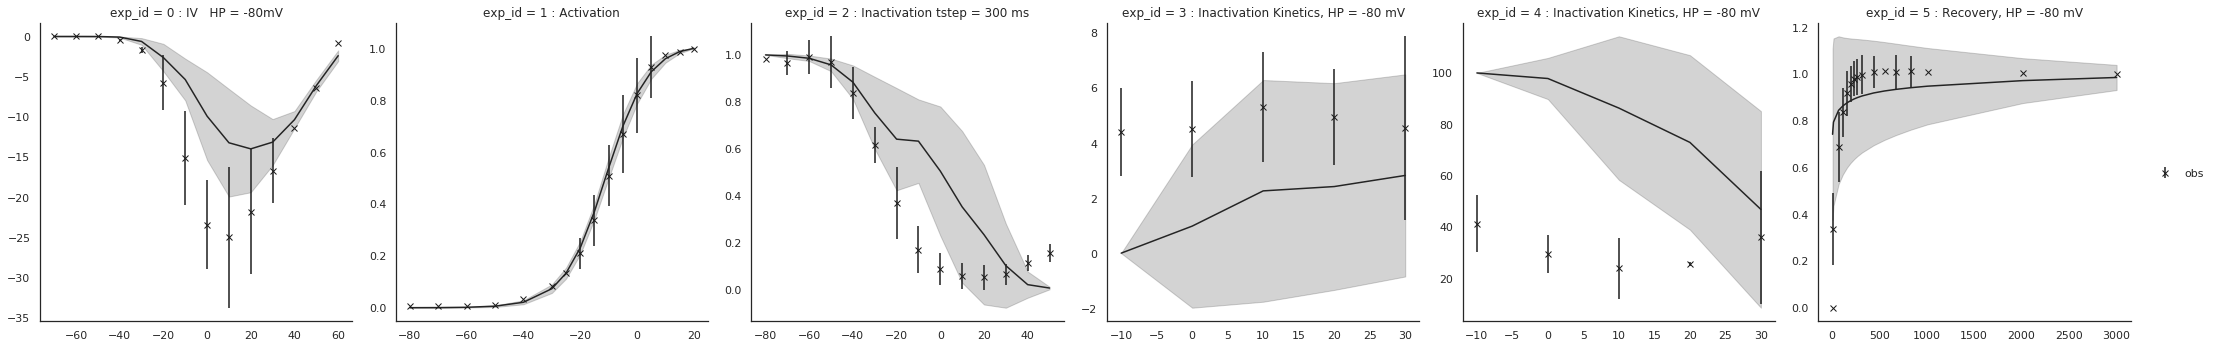

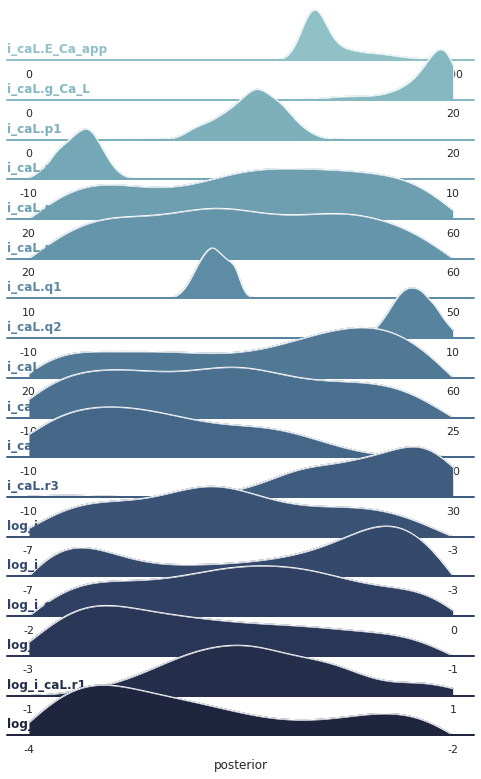

In [29]:
history = History(db_path)
history.id = 18

## Note, those runs have used the 1000 factor in the time constants 

# Li experiments :

# IV corresponds to Li_iv_80 (HP = -80 mV)
# act corresponds to Li_act
# inact corresponds to Li_inact_300 (tstep = 300 ms)
# time constants corresponds to Li_inact_kin_80 (HP = -80 mV)
# recovery corresponds to Li_recov_80 (HP = -80 mV)
# all experiments corresponds to Li_iv_80, Li_act,Li_inact_300,Li_recov_80


# history.id correspondance :

# for plotting the posterior of following runs, load the limit : limits_g_cal_log

# 6 corresponds to the time constant (1000 factor, but the result show that the time constant are retrievable)
# eps = 1.03 (37 iter)
# 7 corresponds to the recovery, eps = 0.144 (10 iter) : sucess 
# 13 corresponds to act, eps = 0.17 : success 
# 15 corresponds to IV, act, inact eps = 0.7697 (8 iter) : success

# for plotting the posterior of following runs, load the limit : limits_g_cal

# 16 corresponds to all but time constant : eps = 0.4964 (18 iter) success.
# 17 correponds to recovery HP = -40mV to check that all the recovery experiments are retrievable
# by the nygren ical. eps = 0.271 (7 iter) : success. 

df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,
                                                Li_iv_80,
                         Li_act,
                         Li_inact_300,
                         Li_inact_kin_80,
                         Li_recov_80,
                                                df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)